In [ ]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install --upgrade setuptools

In [30]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import re
import os
import random
import tensorflow as tf

from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, f1_score, confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B1
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from PIL import Image
from scipy.stats import skew
from tqdm import tqdm
from tensorflow.keras.models import load_model, save_model

In [ ]:
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []
for dirname, _, filenames in os.walk("D:/PES/ML stuff/CIE PAML/Project/Data/Non Demented"):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk("D:/PES/ML stuff/CIE PAML/Project/Data/Very mild Dementia"):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename)) 
        
for dirname, _, filenames in os.walk("D:/PES/ML stuff/CIE PAML/Project/Data/Mild Dementia"):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk("D:/PES/ML stuff/CIE PAML/Project/Data/Moderate Dementia"):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))
        


In [ ]:
print(len(non_demented))
print(len(very_mild_demented))
print(len(mild_demented))
print(len(moderate_demented))

67222
13725
5002
488


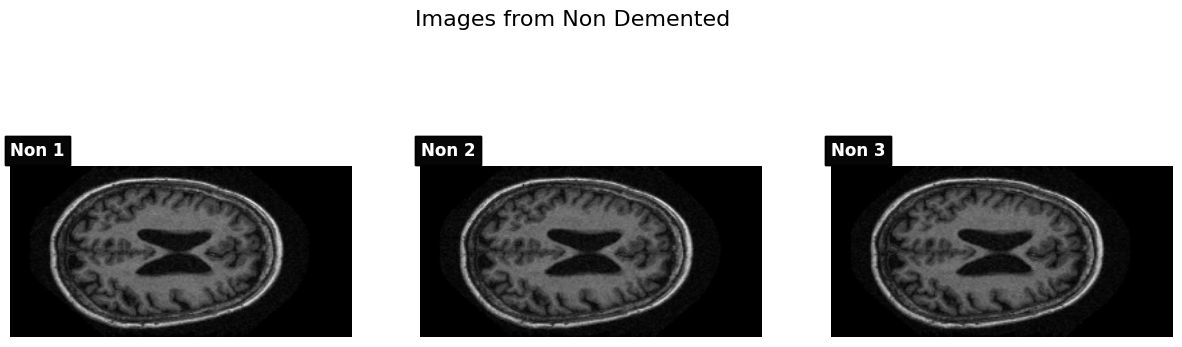

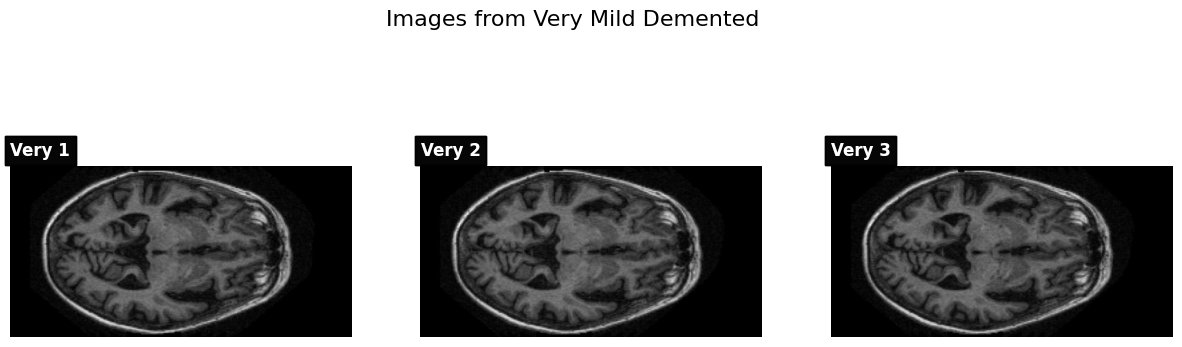

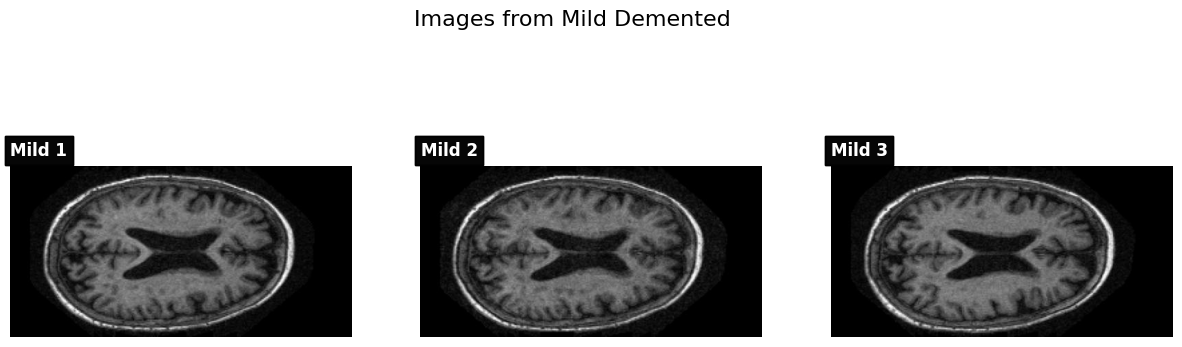

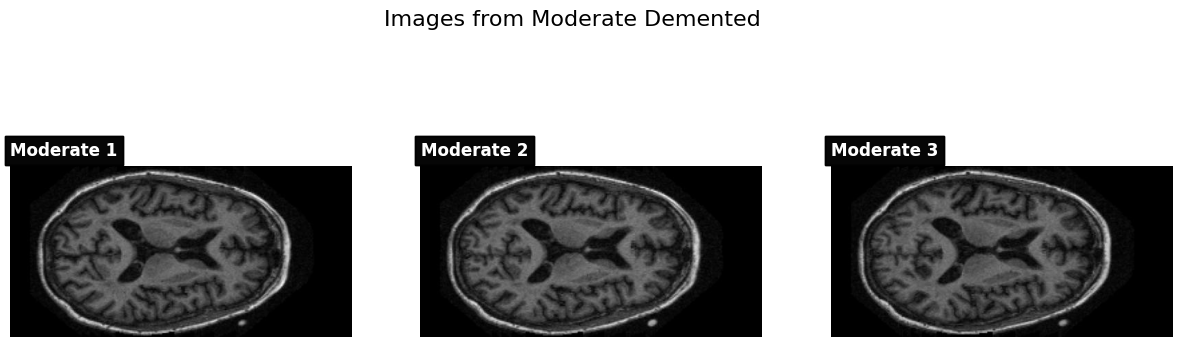

In [ ]:
# Function to display images with text indicating the category
def display_images_with_text(file_paths, category_name, endings=['150', '151', '152']):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Images from {category_name}", fontsize=16)

    for ending in endings:
        matching_files = [img for img in file_paths if img.endswith(ending + '.jpg')]
        for i in range(min(3, len(matching_files))):
            img_path = matching_files[i]
            img = Image.open(img_path)
            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')
            
            # Add text indicating the category
            plt.text(0, -10, f"{category_name.split()[0]} {i + 1}", color='white', fontsize=12, weight='bold', ha='left', va='bottom', bbox=dict(facecolor='black', alpha=0.7))

    plt.show()

# Display images with text for each category
display_images_with_text(non_demented, "Non Demented")
display_images_with_text(very_mild_demented, "Very Mild Demented")
display_images_with_text(mild_demented, "Mild Demented")
display_images_with_text(moderate_demented, "Moderate Demented")

# OVERVIEW

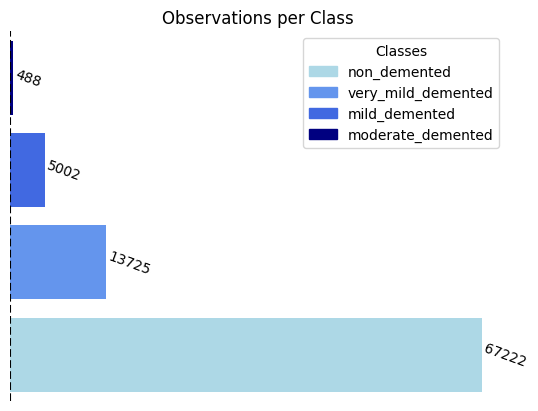

In [ ]:
# Defining class_names, frequencies
frequencies = [len(non_demented),  len(very_mild_demented), len(moderate_demented), len(mild_demented),]
class_names = ["non_demented", "very_mild_demented", "moderate_demented", "mild_demented"]

# Sorting class_names and frequencies in descending order
sorted_indices = np.argsort(frequencies)[::-1]
class_names = np.array(class_names)[sorted_indices]
frequencies = np.array(frequencies)[sorted_indices]

# Navy blue gradient color palette with 4 distinct colors
navy_blue_palette = LinearSegmentedColormap.from_list("navy_blue_palette", ["lightblue", "cornflowerblue", "royalblue", "navy"], N=4)

# Bar plot with adjusted y-axis limits and navy blue gradient colors
fig, ax = plt.subplots()
bp = ax.barh(np.arange(len(class_names)), frequencies, color=navy_blue_palette(np.linspace(0, 1, len(class_names))))

# Adjusted y-axis limits
ax.set_ylim(-0.5, len(class_names)-0.5)

# Class names as y-axis labels
ax.set_yticks(np.arange(len(class_names)))
ax.set_yticklabels(class_names)

# Hide axes
ax.axis('off')

# Frequency values to the right of each bar with a reduced offset
for i, frequency in enumerate(frequencies):
    ax.text(frequency + 0.1, i, frequency, ha='left', va='center', rotation=-20)

# Vertical line at 0 for clarity
ax.axvline(x=0, linestyle='--', color='black')

# Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=navy_blue_palette(i)) for i in range(4)]
ax.legend(handles, class_names, loc="upper right", title="Classes")

# Plot title
plt.title("Observations per Class")

plt.show()

# Data Preprocessing

In [ ]:
# Set seed for random sampling
random.seed(42)


# Split off a test set for the moderate_demented class
moderate_demented_train, moderate_demented_test = train_test_split(
    moderate_demented, test_size=0.2, random_state=42
)

# Split off a test set for the mild_demented class
mild_demented_train, mild_demented_test = train_test_split(
    mild_demented, test_size=0.2, random_state=42
)

# Split off a test set for the very_mild_demented class
very_mild_demented_train, very_mild_demented_test = train_test_split(
    very_mild_demented, test_size=0.2, random_state=42
)

# Split off a test set for the non_demented class
non_demented_train, non_demented_test = train_test_split(
    non_demented, test_size=0.2, random_state=42
)

## Handling the Imbalance

In [ ]:
# Check number of train images per category
print(len(non_demented_train))
print(len(very_mild_demented_train))
print(len(mild_demented_train))
print(len(moderate_demented_train))

53777
10980
4001
390


In [ ]:
# Specify the target number of samples for each class
target_samples = 5000

# Oversample small classes
moderate_demented_samp = random.choices(moderate_demented_train, k=target_samples)
mild_demented_samp = random.choices(mild_demented_train, k=target_samples)

# Undersample large classes
very_mild_demented_samp = random.sample(very_mild_demented_train, k=target_samples)
non_demented_samp = random.sample(non_demented_train, k=target_samples)

In [ ]:
# Check results
print(len(non_demented_samp))
print(len(very_mild_demented_samp))
print(len(mild_demented_samp))
print(len(moderate_demented_samp))

5000
5000
5000
5000


In [ ]:
# Check the number of test images per category
print(len(non_demented_test))
print(len(very_mild_demented_test))
print(len(mild_demented_test))
print(len(moderate_demented_test))

13445
2745
1001
98


In [ ]:
# Specify the target number of samples for each class
target_samples = 640

# Undersample large classes
mild_demented_test = random.sample(mild_demented_test, k=target_samples)
very_mild_demented_test = random.sample(very_mild_demented_test, k=target_samples)
non_demented_test = random.sample(non_demented_test, k=target_samples)

In [ ]:
# One-hot encoder for class labels 
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [16]:
# Empty objects to store the data and the class labels (result) in
data = []
result = []

# Loop through each category and transform data and result into right format (128x128x3 & one-hot encoded) 
# and merge categories together
for path in non_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

for path in very_mild_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())
        
for path in mild_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray()) 
        
for path in moderate_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())

In [17]:
# Transform data to numpy array
data = np.array(data)

# Check shape
data.shape

(20000, 128, 128, 3)

In [18]:
# Transform labels to numpy array
result = np.array(result)

# Reshape to the one-hot encoded format 
result = result.reshape((data.shape[0],4)) 

# Check shape 
result.shape

(20000, 4)

In [19]:
# Split in validation and train data 
x_train,x_val,y_train,y_val = train_test_split(data,result, test_size=0.20, shuffle=True, random_state=42)

In [20]:
### Transforming the data into the right shape (128x128x3), merge and encode it 

data_test = []
result_test = []

for path in non_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[0]]).toarray())
        
for path in very_mild_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[1]]).toarray())
        
for path in mild_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[2]]).toarray()) 
        
for path in moderate_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[3]]).toarray())

In [21]:
# Transform data to numpy array
data_test = np.array(data_test)
data_test.shape

(2018, 128, 128, 3)

In [22]:
# Transform labels to numpy array
result_test = np.array(result_test)
result_test = result_test.reshape((data_test.shape[0],4)) 
result_test.shape

(2018, 4)

In [23]:
# Change names to x_test and y_test 
x_test = data_test
y_test = result_test

| Data Object   | Description                                                 |
|:--------------|:------------------------------------------------------------|
| `x_train`     | Train data used in the modeling process.                    |
| `y_train`     | Train labels associated with the train data.                  |
| `x_val`       | Validation data used in the modeling process to evaluate performance. |
| `y_val`       | Validation labels associated with the validation data.          |
| `x_test`      | Test data used to evaluate the final model performance.        |
| `y_test`      | Test labels associated with the test data.                     |

In [24]:
# Convert labels to integers
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)

In [25]:
# Load the pre-trained EfficientNetB0 model without top (classification) layers
pretrained_base_EfficientNetB0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Make the weights of the pretrained base trainable ("unfreeze")
pretrained_base_EfficientNetB0.trainable = True

# Create a custom model on top of the pre-trained base
model_EfficientNetB0 = models.Sequential([
    pretrained_base_EfficientNetB0,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(), # reduces feature maps to a single value, so no additional 'flatten' layer needed (also reduces the nr of parameters)
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# Summary of the model
model_EfficientNetB0.summary(print_fn=lambda x: print(x))

Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼─────────────────────

In [27]:
# Use integer labels: y_train_int & y_val_int

# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile the model
model_EfficientNetB0.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)

# Train the model with early stopping
history_EfficientNetB0 = model_EfficientNetB0.fit(x_train, y_train_int, epochs=1, batch_size=16,
                                                  verbose=1, validation_data=(x_val, y_val_int), callbacks=[early_stopping])

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 570s 548ms/step - accuracy: 0.8038 - loss: 0.5149 - val_accuracy: 0.8510 - val_loss: 0.3720


In [32]:
save_model(model_EfficientNetB0, 'efficientnetb0_model.keras')

Results


<Axes: >

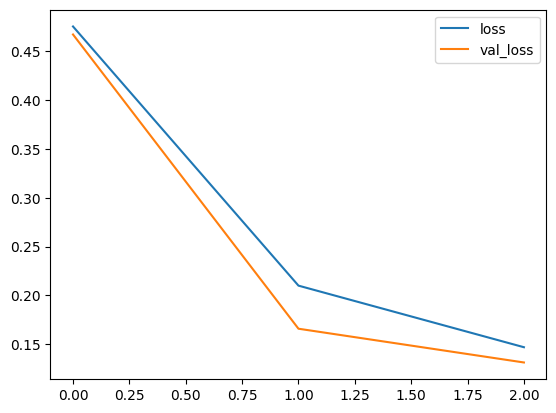

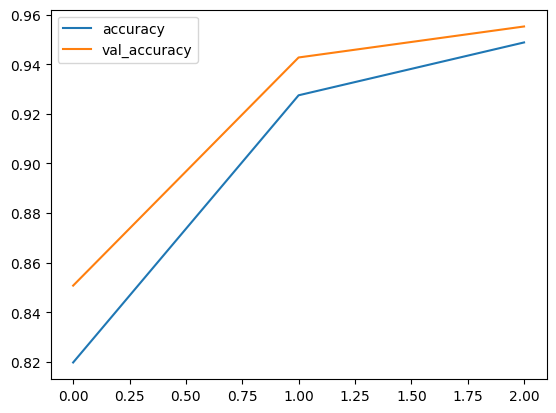

In [64]:
# Loss & accuracy of ordinal model 
history_EfficientNetB0_frame = pd.DataFrame(history_EfficientNetB0.history)
history_EfficientNetB0_frame.loc[:, ['loss', 'val_loss']].plot()
history_EfficientNetB0_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [65]:
# Convert true test labels to integers
y_test_int = np.argmax(y_test, axis=1)

# Evaluate on test set 
testeval = model_EfficientNetB0.evaluate(x_test, y_test_int, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

64/64 - 13s - 204ms/step - accuracy: 0.9420 - loss: 0.1907
Test Loss: 0.19066055119037628
Test Accuracy: 0.9420217871665955


In [66]:
# Use integer test labels: y_test_int

# Convert predicted labels to integers 
y_pred_int = np.argmax(model_EfficientNetB0.predict(x_test), axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_int, y_pred_int)

# Plot confusion matrix on log scale
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, norm=LogNorm())
plt.title('Confusion Matrix (Log Scale)')
plt.colorbar()
classes = np.unique(y_test_int)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

57/64 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step

In [ ]:
# Predicted integer labels: y_pred_int

# One-hot encode the predicted labels
y_pred_one_hot = to_categorical(y_pred_int, num_classes=4)

# True labels one hot encoded: y_test

# True labels integers: y_test_int

# Calculate precision, recall, and F1 score per class --> uses integers
precision, recall, f1, _ = precision_recall_fscore_support(y_test_int, y_pred_int, average=None)

# Print precision, recall, and F1 score for each class
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f'Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1 Score = {f:.4f}')
    
# Calculate micro-averages --> uses one hot encoded labels
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_test, y_pred_one_hot, average='micro')

# Print precision, recall and F1 score micro average
print("Micro-average Precision:", round(micro_precision, 4))
print("Micro-average Recall:", round(micro_recall, 4))
print("Micro-average F1 Score:", round(micro_f1, 4))

In [ ]:
# True labels: y_test

# Predicted probability scores for each class
y_probs = model_EfficientNetB0.predict(x_test)

# Calculate ROC AUC per class
roc_auc_per_class = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)

# Print ROC AUC for each class
for i, auc in enumerate(roc_auc_per_class):
    print(f'Class {i}: ROC AUC = {auc:.4f}')

# Calculate micro-average ROC AUC
roc_auc_micro = roc_auc_score(y_test, y_probs, multi_class='ovr', average='micro')

# Print
print("Micro-average ROC AUC:", round(roc_auc_micro, 4))

In [ ]:
# Scott's pi function
def scotts_pi(confusion_matrix):
    total = np.sum(confusion_matrix)
    observed_agreement = np.trace(confusion_matrix)
    
    row_totals = np.sum(confusion_matrix, axis=1)
    col_totals = np.sum(confusion_matrix, axis=0)
    
    expected_agreement = np.sum((row_totals * col_totals) / total)
    
    pe = expected_agreement / total
    pi = (observed_agreement - expected_agreement) / (total - expected_agreement)
    
    return pi


# True integer labels: y_test_int
y_test_int = np.argmax(y_test, axis=1)

# Predicted integer labels: y_pred_int

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred_int)

# Calculate Scott's Pi
pi = scotts_pi(conf_matrix)
print("Scott's Pi:", pi)

In [1]:
import numpy as np
import cv2
import tkinter as tk
from tkinter import Tk, Label, Button, filedialog, Frame, messagebox
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image, ImageTk

# Global variables
selected_image_path = None

# Function to preprocess image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))  # Resize image to match model input shape
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = img.astype("float32")  # Convert to float32
    img = preprocess_input(img)  # Preprocess input (normalize pixels)
    return img

# Function to make predictions on unseen images
def predict_image(image_path, model):
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    invalid_threshold = 1
    if np.max(prediction) >=invalid_threshold:
        return -1
    print(prediction)
    predicted_class = np.argmax(prediction)
    return predicted_class

# Function to handle file upload
def upload_image():
    global selected_image_path
    selected_image_path = filedialog.askopenfilename()
    if selected_image_path:
        display_image(selected_image_path)
        confirm_button.config(state="normal")  # Enable the confirm button

# Function to display uploaded image
def display_image(image_path):
    img = Image.open(image_path)
    img.thumbnail((300, 300))
    img = ImageTk.PhotoImage(img)
    image_label.config(image=img)
    image_label.image = img

# Function to confirm selection
def confirm_selection():
    if selected_image_path:
       
            predicted_class = predict_image(selected_image_path, model_EfficientNetB0)
            if predicted_class == 0:
                result_label.config(text="Non Demented case of Alzheimer's")
            elif predicted_class == 1:
                result_label.config(text="Very Mildly Demented case of Alzheimer's")
            elif predicted_class == 2:
                result_label.config(text="Mildly Demented case of Alzheimer's")
            elif predicted_class == 3:
                result_label.config(text="Moderately Demented case of Alzheimer's")
            else :
                result_label.config(text="Invalid Input")
        
    else:
        result_label.config(text="No image selected.")


def get_screen_resolution(window):
    # Get the screen width and height
    screen_width = window.winfo_screenwidth()
    screen_height = window.winfo_screenheight()
    return screen_width, screen_height

def create_gradient(canvas, x, y, width, height, start_color, end_color):
    for i in range(height):
        # Calculate the current color based on the gradient
        r = int(start_color[0] + (end_color[0] - start_color[0]) * (i / height))
        g = int(start_color[1] + (end_color[1] - start_color[1]) * (i / height))
        b = int(start_color[2] + (end_color[2] - start_color[2]) * (i / height))
        color = f'#{r:02x}{g:02x}{b:02x}'
        
        # Draw a line of the gradient
        canvas.create_line(x, y + i, x + width, y + i, fill=color)

# Create Tkinter window
root = tk.Tk()
root.title("Alzheimer's Detection")
root.configure(bg = "#F0F0F0")

# Create and place GUI elements with enhanced styling
heading_label = Label(root, text="Alzheimer's Detection", font=("Helvetica", 24, "bold"), bg="#F0F0F0")
heading_label.pack(pady=20)

# Frame for file upload
upload_frame = Frame(root, bg="#E5E5E5", padx=20, pady=20)
upload_frame.pack()

upload_label = Label(upload_frame, text="Upload Image", bg="#E5E5E5")
upload_label.pack(side="left")



upload_button = Button(upload_frame, text="Choose File", command=upload_image, bg="#3498db", fg="white", padx=10, pady=5, font=("Arial", 10, "bold"))
upload_button.pack(side="right")

confirm_button = Button(root, text="Confirm Selection", command=confirm_selection, state="disabled", bg="#27ae60", fg="white", padx=10, pady=5, font=("Arial", 10, "bold"))
confirm_button.pack(pady=10)

image_label = Label(root)
image_label.pack(pady=20)

result_label = Label(root, text="", font=("Helvetica", 16, "italic"), wraplength=300)
result_label.pack(pady=10)

root.mainloop()

FileNotFoundError: [Errno 2] No such file or directory: 'cloud.png'